In [1]:
############################################################################
################       █████   █████████  ███████████       ################ 
################      ░░███   ███░░░░░███░█░░░███░░░█       ################ 
################       ░███  ███     ░░░ ░   ░███  ░        ################ 
################       ░███ ░███             ░███           ################ 
################       ░███ ░███             ░███           ################ 
################       ░███ ░░███     ███    ░███           ################ 
################       █████ ░░█████████     █████          ################ 
################       ░░░░░   ░░░░░░░░░     ░░░░░          ################ 
############################################################################
########                IRI PROGRESSION MODEL (MPEDG)             ##########
################           Project: R27-252 EV             #################
########     Originally written by: Aravind Ramakhrishnan        ###########
############################################################################

# Created on Sat May 28 21:10:59 2022
# Last modified on Fri Jul 27 9:10:59 2024
# @author: Johann-Cardenas

In [3]:
# Import libraries
import numpy as np
import pandas as pd
import time

# Import modules
import Temperature_Parameters as TP
import Expected_strain as ES
import Rut_calc_RP_v4 as RC_V4
import Fatigue_calc as FC
import IRI_calc

# Start time tracker
start = time.time()

In [12]:
# =============================================================================
# INITIALIZING PARAMETERS
# =============================================================================
bin_npl = np.linspace(-24.5,24.5,99)              # Bin for non-platoon
bin_pl = np.array([[-24,-22],[-1,1],[22,24]])     # Bin for platoon
prob_pl = np.array([1/3,1/3,1/3])                 # Probability for platoon
PS = 1                                            # Platoon Size
PL = 0                                           # Penetration Level in %
GR = 0.01                                         # Traffic growth rate
AP = 20                                           # Analysis period (years)
RPFactor = 0.0096                                 # Roughness Progression Factor (assumption)

In [13]:
# =============================================================================
# TRAFFIC AND STRUCTURE
# =============================================================================
Traffic = pd.ExcelFile('Traffic.xlsx')          # Load Traffic Data 
Sheet_Names = Traffic.sheet_names               # Get Sheet Names
AMDTT, AADTT, Axles_per_TruckClass, Normalized_Truck_Dist, Single_Axle, Tandem_Axle = [Traffic.parse(i) for i in Sheet_Names]  # Load Data from Sheets
P_si = Single_Axle['Bin_Center_kN'].values/1./2.   # Single Axle Load in kN
P_ta = Tandem_Axle['Bin_Center_kN'].values/1./2.   # Tandem Axle Load in kN
PP = [P_si, P_ta]                              # Axle Load Distribution
Structure = ['NSS','NTS']                      # Type of Structure (Tab name in   'FE_INPUTS.xlsx')
AADTT = AADTT.values[0][0]                     # Annual Average Daily Truck Traffic          
AADTT_yearly = [AADTT*(1+GR)**i for i in range(AP)]   # Annual Average Daily Truck Traffic for Analysis Period

In [27]:
# =============================================================================
# INITIALIZING DISTRESS PARAMETERS
# =============================================================================
rutfinalAC = []
maxrutAC = [0]
rutfinalBase = []
maxrutBase = [0]
rutfinalSubg = []
maxrutSubg = [0]
rutfinal = [0]
rutfinalAC_sd = [0]
rutfinalBase_sd = [0]
rutfinalSubg_sd = [0]
rutfinal_sd = [0]
iteration = 0  # Start iteration
FC_total_max = [0]
DI_BU = np.zeros((99,))
DI_TD = np.zeros((99,))

In [29]:
# =============================================================================
# MAIN CODE
# =============================================================================
np.seterr(invalid='ignore')

for yy in range(AP):
    AADTT_y = AADTT_yearly[yy]
    print(f"Year: {yy+1} of {AP} in progress...")
    for mm in range(12):
        N_ycm_si, N_ycm_ta, N_ycm_tr = 0, 0, 0
        Temp = TP.temperature(mm)   # Current function defaults to T2
        Resp = pd.ExcelFile('FE_INPUTS-'+Temp+'.xlsx').parse(Structure)
        Single = Resp[Structure[0]] # Single Axle Strain Profile for 12 kips axle load
        Tandem = Resp[Structure[1]] # Tandem Axle Strain Profile for 34 kips axle load
        
        for cc in range(10):
            # Range equals number of classes in the data
            AADTT_yc = AADTT_y * Normalized_Truck_Dist['Percent_AADTT'][cc]/100.
            TT_ycm = 30. * AADTT_yc * AMDTT['Class_' + str(cc+4)][mm]/100.  # Truck Traffic in a month, counter added to match Class_4 to Class_0
            Si = TT_ycm * Axles_per_TruckClass['Single'][cc]
            Ta = TT_ycm * Axles_per_TruckClass['Tandem'][cc]
            N_ycm_si += Si * Single_Axle['Class_' + str(cc+4)].values/100.
            N_ycm_ta += Ta * Tandem_Axle['Class_' + str(cc+4)].values/100.
        
        NN = [N_ycm_si, N_ycm_ta]
        iteration += 1   # Iteration index starts at 1, replacing previous definition
    
        # =============================================================================
        # Truck parameters initialization        
        # =============================================================================
        Total_Trucks = np.sum(NN[0]) # Total Number of Trucks equals number of Single Axles
        Pl_Trucks = int(Total_Trucks*PL/100) # Total Number of Trucks in platoon
        Pl_groups = int(Pl_Trucks/PS) # Total number of platoons
        Npl_Trucks = int(Total_Trucks - Pl_groups*PS) # Manual Traffic
        s_normal = np.random.normal(0,10,Npl_Trucks)  # Normal distribution of non-platoon trucks
        b = np.histogram(s_normal,bins=np.linspace(-24.75, 24.75,100)) # Histogram of non-platoon trucks
        freq_npl = b[0]  # Frequency of non-platoon trucks
        freq_pl = []     # Frequency of platoon trucks
        
        for i in range(len(bin_pl)):
            s = np.random.uniform(bin_pl[i][0],bin_pl[i][1],int(prob_pl[i]*Pl_groups))
            b = np.histogram(s,bins=np.linspace(bin_pl[i][0], bin_pl[i][1],6))
            freq_pl.append(b[0])
            
        freq_pl = np.array(freq_pl)
        IP_npl = np.concatenate([(bin_npl[i]*np.ones((freq_npl[i],))) 
                                       for i in range(len(freq_npl))])
        np.random.shuffle(IP_npl)
        locs = np.linspace(bin_pl[:,0],bin_pl[:,1],5).T
        IP_pl = np.concatenate([(locs[i][j]*np.ones((freq_pl[i][j],)))
                 for i in range(len(freq_pl)) for j in range(len(freq_pl[0]))])
        np.random.shuffle(IP_pl)
        InputMat = np.append(PS*np.ones(Pl_groups),np.ones(sum(freq_npl)))
        
        #np.random.shuffle(InputMat)
        # =============================================================================
        # Expected Strain
        # =============================================================================
        FER_rut_AC = ES.Expected(freq_npl, bin_npl, freq_pl, bin_pl, PS, Single, Tandem, RPFactor)
        cols = len(FER_rut_AC) # Transverse Strain Profile bins
        FER_rut_UB = ES.Expected(freq_npl, bin_npl, freq_pl, bin_pl, PS, Single, Tandem, 1)
        
        # =============================================================================
        # Rutting calculation        
        # =============================================================================
        if iteration == 1 and (Structure == ['NSS','NTS'] or Structure == ['NSW','NTW']):
            rutAC_D, rutAC_ref = np.zeros((5,cols)), np.zeros((5,cols)) # AC divided in 5 layers
            rutB_D = np.zeros((3,cols))  # Base divided in 3 layers
            rutS_D = np.zeros((2,cols))  # SG divided in 2 layers
        elif iteration == 1 and (Structure == ['KSS','KTS'] or Structure == ['KSW','KTW']):
            rutAC_D, rutAC_ref = np.zeros((7,cols)), np.zeros((7,cols)) # AC divided in 7 layers
            rutB_D = np.zeros((3,cols)) # Base divided in 3 layers
            rutS_D = np.zeros((2,cols)) # SG divided in 2 layers
        
        #________________________________________________________________________________    
        # AC Rutting#
        rutAC_D, rutAC_ref = RC_V4.ACrutting(Structure, Temp, FER_rut_AC, Single, Tandem, 
                                  InputMat, RPFactor, rutAC_D, rutAC_ref,IP_npl,IP_pl)      
                         
        rutfinalAC.append(np.sum(rutAC_D,0))
        maxrutAC.append(max(np.sum(rutAC_D,0)))
        
        #________________________________________________________________________________    
        # Base and Subgrade Rutting
        rutB_D, rutS_D = RC_V4.Unboundrutting(Structure, Temp, FER_rut_UB, Single, Tandem, 
                                              InputMat, rutB_D, rutS_D,IP_npl,IP_pl)
        
        rutfinalBase.append(np.sum(rutB_D,0))
        maxrutBase.append(max(np.sum(rutB_D,0)))
        
        rutfinalSubg.append(np.sum(rutS_D,0))
        maxrutSubg.append(max(np.sum(rutS_D,0)))
        
        # =============================================================================
        # Fatigue Calculation
        # =============================================================================
        BU_Nf_s, BU_Nf_t = FC.Nf_cracking(Structure, Single, Tandem, InputMat, 'BU')
        TD_Nf_s, TD_Nf_t = FC.Nf_cracking(Structure, Single, Tandem, InputMat, 'TD')
        DI_bu, DI_td = ES.Expected_Nf(freq_npl, bin_npl, freq_pl, bin_pl, PS, 
                                    [1/0.44/BU_Nf_s,1/TD_Nf_s], [1/0.44/BU_Nf_t,1/TD_Nf_t])
        
        DI_BU += DI_bu
        DI_TD += DI_td
        FC_BU = FC.FC_BU_(DI_BU, Structure)
        FC_TD = FC.FC_TD_(DI_TD)
        DI_prev_BU, DI_prev_TD = DI_BU, DI_TD
        FC_total_max.append(max(FC_BU+FC_TD*100/5280.))

Year: 1 of 20 in progress...
Year: 2 of 20 in progress...
Year: 3 of 20 in progress...
Year: 4 of 20 in progress...
Year: 5 of 20 in progress...
Year: 6 of 20 in progress...
Year: 7 of 20 in progress...
Year: 8 of 20 in progress...
Year: 9 of 20 in progress...
Year: 10 of 20 in progress...
Year: 11 of 20 in progress...
Year: 12 of 20 in progress...
Year: 13 of 20 in progress...
Year: 14 of 20 in progress...
Year: 15 of 20 in progress...
Year: 16 of 20 in progress...
Year: 17 of 20 in progress...
Year: 18 of 20 in progress...
Year: 19 of 20 in progress...
Year: 20 of 20 in progress...


In [16]:
rutfinalAC = np.array(rutfinalAC)
maxrutAC = np.array(maxrutAC)
rutfinalBase = np.array(rutfinalBase)
maxrutBase = np.array(maxrutBase)
rutfinalSubg = np.array(rutfinalSubg)
maxrutSubg = np.array(maxrutSubg)
maxrut = maxrutAC + maxrutBase + maxrutSubg
rutfinal = rutfinalAC + rutfinalBase + rutfinalSubg
FC_total_max = np.array(FC_total_max)*100
IRI_max = IRI_calc.IRI_(FC_total_max, maxrut, np.linspace(0,AP,12*AP+1), 0)
Total_Combined = pd.DataFrame(np.array([maxrutAC, maxrut,FC_total_max,IRI_max]).T,
                              columns=['AC_rut','Total_rut','FC','IRI'])


end = time.time()
elapsed = (end - start)
print('Elapsed Time:', format(elapsed, '.2f'), 'seconds.')

Elapsed Time: 516.36 seconds.


In [37]:
# Generating Continuous Outputs
x1 = np.arange(len(IRI_max))
y1 = IRI_max
spl1 = make_interp_spline(x1, y1, k=5)  # k is the degree of the spline
x1_smooth = np.linspace(x1.min(), x1.max(), 2500)
y1_smooth = spl1(x1_smooth)

x2 = np.arange(len(maxrut))
y2 = maxrut
spl2 = make_interp_spline(x2, y2, k=5)  # k is the degree of the spline
x2_smooth = np.linspace(x2.min(), x2.max(), 2500)
y2_smooth = spl2(x2_smooth)

x3 = np.arange(len(FC_total_max))
y3 = FC_total_max
spl3 = make_interp_spline(x3, y3, k=5)  # k is the degree of the spline
x3_smooth = np.linspace(x3.min(), x3.max(), 2500)
y3_smooth = spl3(x3_smooth)

In [42]:
len(IRI_max), len(maxrut), len(FC_total_max)

(241, 241, 481)

### **Plots**

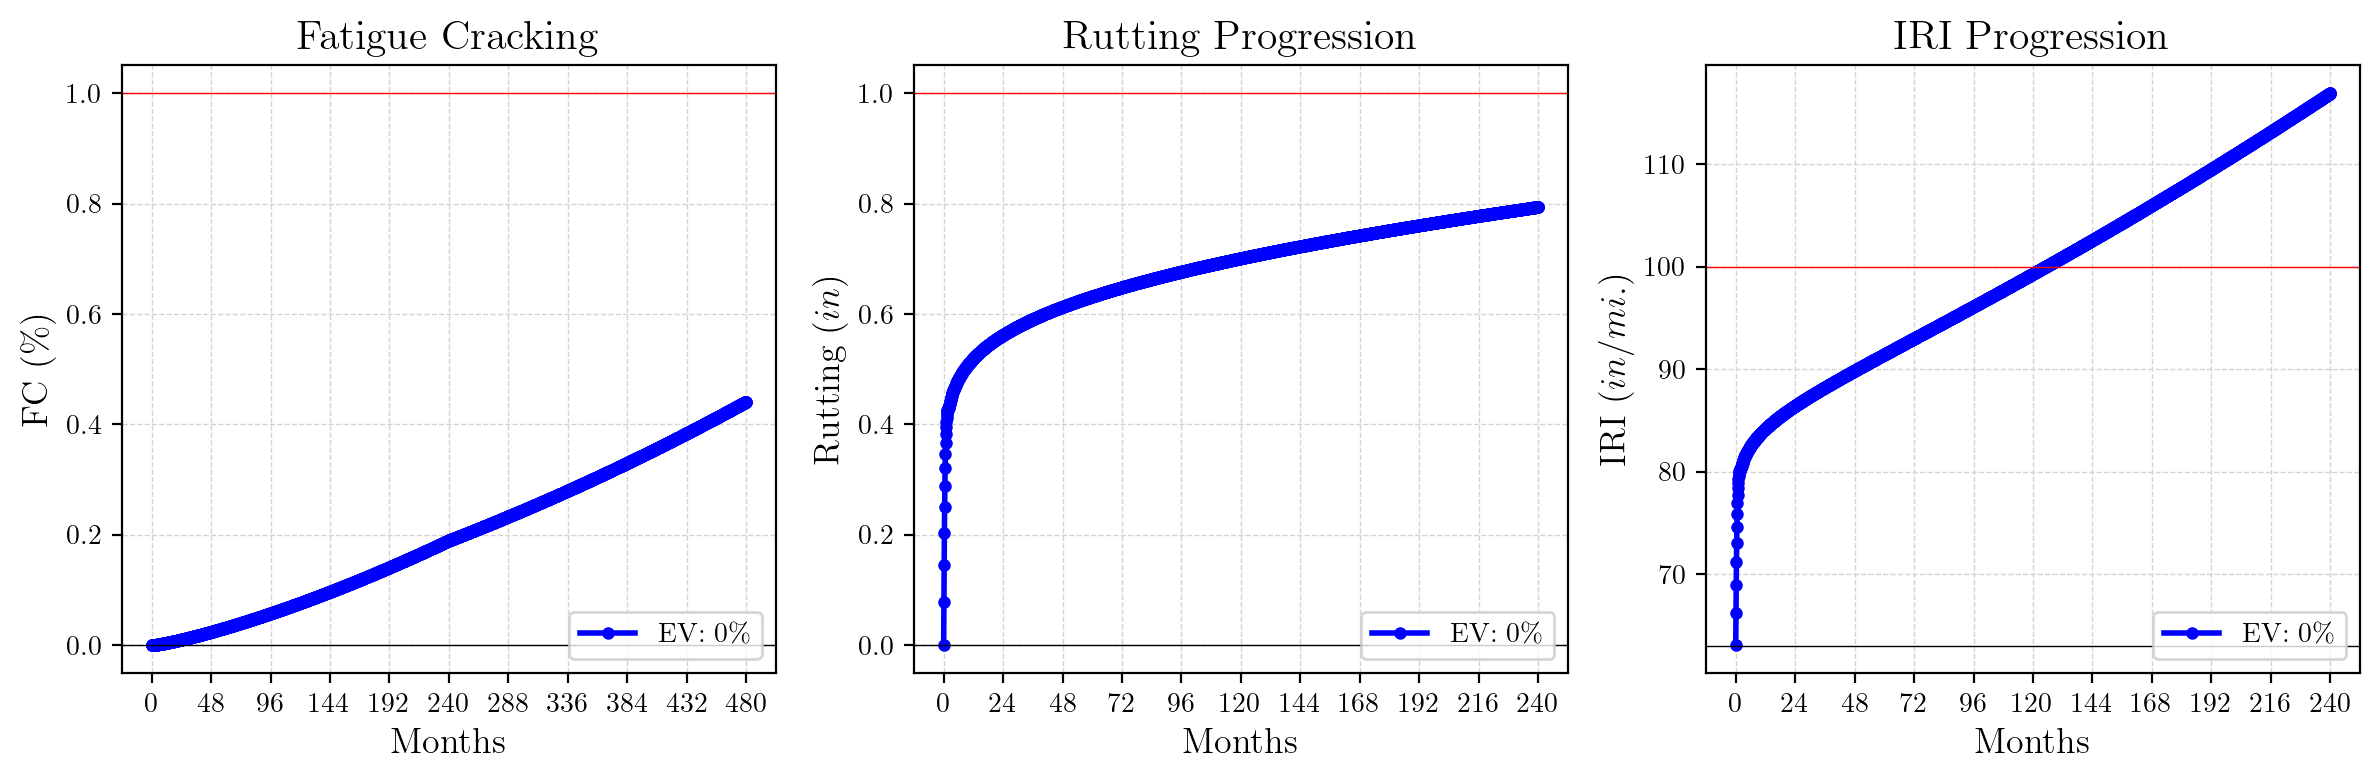

In [43]:

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=200)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Fatigue Cracking Progression
ax1.plot(x3_smooth, y3_smooth, '-b', marker='o', markeredgecolor='blue', markersize=4, markeredgewidth=0.5, linewidth=2.0, zorder=1, label='EV: $0\%$')
ax1.axhline(0, color='black', linewidth=0.5)  # Initial IRI
ax1.axhline(1, color='red', linewidth=0.5)   # Threshold IRI
ax1.set_xlabel('Months', fontsize=13)
ax1.set_ylabel('FC ($\%$)', fontsize=13)
ax1.set_xticks(np.arange(0, len(FC_total_max), 48))
# show xticks divided by 2


ax1.tick_params(axis='x', labelsize=10)
ax1.grid(color='lightgrey', linestyle='--', linewidth=0.50, zorder=0)
ax1.set_axisbelow(True)  # Sends gridlines to the back
ax1.set_title('Fatigue Cracking', fontsize=15)
ax1.legend(loc='lower right', fontsize=10)

# Rutting Progression
ax2.plot(x2_smooth, y2_smooth, '-b', marker='o', markeredgecolor='blue', markersize=4, markeredgewidth=0.5, linewidth=2.0, zorder=1, label='EV: $0\%$')
ax2.axhline(0, color='black', linewidth=0.5)  # Initial IRI
ax2.axhline(1, color='red', linewidth=0.5)   # Threshold IRI
ax2.set_xlabel('Months', fontsize=13)
ax2.set_ylabel('Rutting ($in$)', fontsize=13)
ax2.set_xticks(np.arange(0, len(maxrut), 24))
ax2.tick_params(axis='x', labelsize=10)
ax2.grid(color='lightgrey', linestyle='--', linewidth=0.50, zorder=0)
ax2.set_axisbelow(True)  # Sends gridlines to the back
ax2.set_title('Rutting Progression', fontsize=15)
ax2.legend(loc='lower right', fontsize=10)

# IRI Progression
ax3.plot(x1_smooth, y1_smooth, '-b', marker='o', markeredgecolor='blue', markersize=4, markeredgewidth=0.5, linewidth=2.0, zorder=1, label='EV: $0\%$')
ax3.axhline(63, color='black', linewidth=0.5)  # Initial IRI
ax3.axhline(100, color='red', linewidth=0.5)   # Threshold IRI
ax3.set_xlabel('Months', fontsize=13)
ax3.set_ylabel('IRI ($in/mi.$)', fontsize=13)
ax3.set_xticks(np.arange(0, len(IRI_max), 24))
ax3.tick_params(axis='x', labelsize=10)
ax3.grid(color='lightgrey', linestyle='--', linewidth=0.50, zorder=0)
ax3.set_axisbelow(True)  # Sends gridlines to the back
ax3.set_title('IRI Progression', fontsize=15)
ax3.legend(loc='lower right', fontsize=10)


# Show plot
plt.tight_layout()
plt.show()